<a href="https://colab.research.google.com/github/sdesai38/5105_SD/blob/main/Desai_Shamik_IntroToML_HW3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this homework, we will use the Diabetes dataset and Cancer dataset. (Note: You can use the built-in function from ML libraries for gradient descent, training, and validation.)

Problem 1:
Using the diabetes dataset, build a logistic regression binary classifier for positive diabetes.
- Please use 80% and 20% split between training and evaluation (test). ###
-  Make sure to perform proper scaling and standardization before your training.  ###
- Draw your training results, including loss and classification accuracy over iterations. ###
- Also, report your results, including accuracy, precision, and recall, FI score. At the end, plot the confusion matrix representing your binary classifier.

In [761]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn.linear_model import LogisticRegression
drive.mount('/content/drive')
filepath = '/content/drive/My Drive/IntroToMLDataSets/diabetes.csv'
dataset = pd.DataFrame(pd.read_csv(filepath))
dataset.head()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [762]:
#add input for nulll values with column mean or remove entire row of data points, the null data is messing with the loss function calculated through the gradient descent.

In [763]:
#Split and processing

from sklearn.preprocessing import MinMaxScaler as Norm
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

X = dataset.iloc[:, :-1].replace(0, np.nan)
y = dataset.iloc[:, -1]

imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

X_imputed_df = pd.DataFrame(X_imputed, columns=X.columns, index=dataset.index)

dataset = pd.concat([X_imputed_df, y], axis=1)
#data has missing values, adding the input column mean as replacement for empty values in all but last column.


scaler = Norm()
num_vars = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
dataset[num_vars] = scaler.fit_transform(dataset[num_vars])
np.random.seed(0)
df_train, df_test = train_test_split(dataset, train_size = 0.8, test_size = 0.2, random_state = 100)
df_train.head()
#display(df_train.iloc[:5,:-1])
#display(df_train.iloc[:5,-1])

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
660,0.5625,0.761290,0.612245,0.240798,0.170130,0.194274,0.044406,0.550000,0
69,0.1875,0.658065,0.622449,0.217391,0.103365,0.218814,0.047395,0.100000,0
85,0.0625,0.425806,0.510204,0.239130,0.133413,0.290389,0.264731,0.100000,0
219,0.2500,0.438710,0.428571,0.240798,0.170130,0.400818,0.078138,0.333333,1
712,0.5625,0.548387,0.387755,0.315217,0.170130,0.470348,0.154996,0.283333,1


In [764]:
def sigmoid(z):
  return (1 / (1+np.exp(-z)))

In [765]:
def compute_cost(X, Y, theta, beta):

  """
  Parameters(for the single variable calculation):
  X: 2D array where each row reperesent the training example and each column represent the
standardization is to be preprocessing the data. The x' = x_j^i - u_j / s_j
s_j - standard deviation
u_j - mean of the feature
NO REGULARIZATION ON THE THETA DONT TOUCH!!!!!

Adjusting compute_cost for logistic Regression

  """
  m = len(Y)

  predictions = sigmoid(X.dot(theta))
  predictions = np.clip(predictions, 1e-15, 1-1e-15)
  log_errors = np.sum(-Y*np.log(predictions) - (1-Y)*np.log(1-predictions)) #np.subtract(predictions, Y)
  cost = log_errors
  reg = (beta/(2*m))*np.sum(np.square(theta[1:]))
  J = ((1/(m))*cost) + reg
  predClip = np.clip(predictions, 1e-15, 1-1e-15)
  y0 = (Y == 0)
  y1 = (Y == 1)
  m0 = np.sum(y0)
  m1 = np.sum(y1)

  if m1 > 0:
    loss_y1 = np.sum(-np.log(predClip[y1]))/m1
  else:
    loss_y1 = 0.0


  if m0 > 0:
    loss_y0 = np.sum(-np.log(1-predClip[y0]))/m0
  else:
    loss_y0 = 0.0

  cmf_matrix_train = confusion_matrix(Y, np.round(predictions)) #computes the current cfm
  TP = cmf_matrix_train[0,0]
  TN = cmf_matrix_train[1,1]
  FP = cmf_matrix_train[0,1]
  FN = cmf_matrix_train[1,0]
  accuracy_train = (TP + TN) / (TP + TN + FP + FN)

  return J, loss_y1, loss_y0, accuracy_train

In [766]:
def gradient_descent_reg(X_train, Y_train, X_test, Y_test, theta, alpha, iterations,beta):

  from sklearn.metrics import confusion_matrix

  m = len(Y_train)
  train_cost_history = np.zeros(iterations)
  test_cost_history = np.zeros(iterations)

  train_cost_y0history = np.zeros(iterations)
  train_cost_y1history = np.zeros(iterations)

  test_cost_y0history = np.zeros(iterations)
  test_cost_y1history = np.zeros(iterations)

  cmf_history_train = np.zeros(iterations)
  cmf_history_test = np.zeros(iterations)

  accuracy_history_train = np.zeros(iterations)
  accuracy_history_test = np.zeros(iterations)

  for i in range(iterations):
    #Forward Pass
    predictions = sigmoid(X_train.dot(theta))


    #if needed, add predictions for test per iteration in order to check accuracy of the model as gradient decent iterates
    errors = np.subtract(predictions,Y_train)


    penalty = (beta/m)*theta
    penalty[0] = 0;
    sum_delta = alpha* ((1 / m) * X_train.transpose().dot(errors) + penalty)
    theta -= sum_delta
    train_cost_history[i], train_cost_y1history[i],train_cost_y0history[i], accuracy_history_train[i]  = compute_cost(X_train, Y_train, theta, beta)
    test_cost_history[i], test_cost_y1history[i],test_cost_y0history[i], accuracy_history_test[i] = compute_cost(X_test, Y_test, theta, beta)

  return theta, train_cost_history, test_cost_history, train_cost_y0history, train_cost_y1history, accuracy_history_train, accuracy_history_test,

In [767]:
from sklearn.metrics import accuracy_score


#--Model-From-sci-kit-here--#
xtrain = df_train.iloc[:,:-1]
ytrain = df_train.iloc[:,-1]

xtrain = xtrain.to_numpy()
ytrain = ytrain.to_numpy()
model = LogisticRegression()
model.fit(xtrain, ytrain)



print(model.coef_)


print(model.score(xtrain, ytrain))

[[1.39490705 4.43630398 0.41370402 0.76599166 0.56976394 2.44101224
  1.74730806 1.00595431]]
0.7931596091205212


In [768]:
xtest = df_test.iloc[:,:-1]
ytest = df_test.iloc[:,-1]
xtest = xtest.to_numpy()
ytest = ytest.to_numpy()

ypred = model.predict(xtest)
ypred[0:9]

array([0, 0, 1, 0, 0, 1, 1, 0, 1])

In [769]:
#Using confusion matrix to get accuracy:
from sklearn.metrics import confusion_matrix
rpl = confusion_matrix(ytest, ypred)

print(rpl[0,0])

87


In [770]:
np.mean(ytrain)

np.float64(0.3501628664495114)

In [771]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
print("Accuracy", accuracy_score(ytest, ypred))
print("Precision", precision_score(ytest, ypred))
print("Recall", recall_score(ytest, ypred))
print ("F1 Score", f1_score(ytest, ypred))
print("Log Loss", log_loss(ytrain, model.predict_proba(xtrain)))

Accuracy 0.7272727272727273
Precision 0.6410256410256411
Recall 0.4716981132075472
F1 Score 0.5434782608695652
Log Loss 0.45727034470370703


Text(0.5, 427.9555555555555, 'Predicted label')

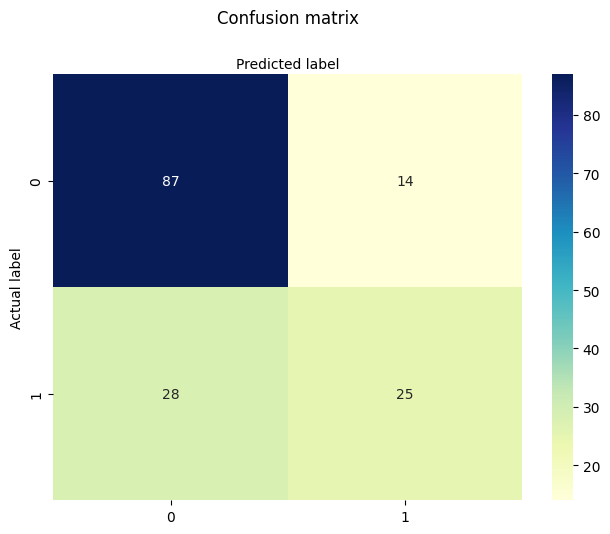

In [772]:
import seaborn as sns
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(confusion_matrix(ytest, ypred)), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

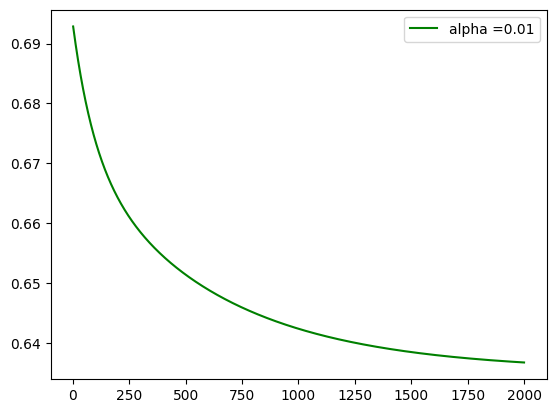

In [773]:
#Applying the functions:
#for manual logRegression in order to track loss. To visualize difference between own function vs sci-kit function
m = len(xtrain)
n = len(xtest)
x0Train = np.ones((m,1));
x0Test = np.ones((n,1));
xtrain = np.hstack((x0Train, xtrain))
xtest = np.hstack((x0Test, xtest))


theta_problem1 = np.zeros(xtrain.shape[1])
alpha_problem1 = 0.01
iterations_problem1 = 2000
beta_problem1 = 100; #start with 0, look at loss and reconfigure


theta_problem1, train_costHist_problem1, test_costHist_problem1, train_costHist_y0problem1, train_costHist_y1problem1, accuracy_scoreTrain_problem1, accuracy_scoreTest_problem1 = gradient_descent_reg(xtrain, ytrain, xtest, ytest, theta_problem1, alpha_problem1, iterations_problem1, beta_problem1)
plt.plot(range(1,iterations_problem1+1),train_costHist_problem1, color = 'green', label = 'alpha =' + str(alpha_problem1))
#plt.plot(range(1,iterations_problem1+1),train_costHist_y0problem1, color = 'orange', label = 'alpha = y0')
#plt.plot(range(1,iterations_problem1+1),train_costHist_y1problem1, color = 'blue', label = 'alpha = y1')
plt.legend()
plt.show()


In [774]:
ytestpredictions = sigmoid(xtrain.dot(theta_problem1))

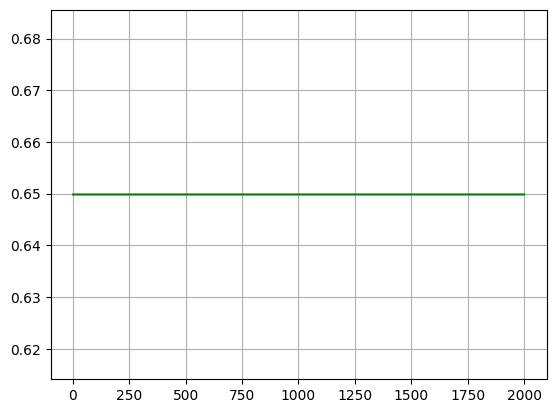

In [775]:
#The attempt to show the accuracy over iterations. The data is too heavily weighted at 0. only 35% of the data is 1
plt.plot(range(1,iterations_problem1+1),accuracy_scoreTrain_problem1, color = 'green', label = 'alpha =' + str(alpha_problem1))
plt.grid(True)
plt.show()

Problem 2 (60pts):

a. Use the cancer dataset to build a logistic regression model to classify the type of cancer (Malignant vs. benign). First, create a logistic regression that takes all 30 input features for classification. Please use 80% and 20% split between training and evaluation (test). Make sure to perform proper scaling and standardization before your training. Draw your training results, including loss and classification accuracy over iterations. Also, report your results, including accuracy, precision, recall and F1 score. At the end, plot the confusion matrix representing your binary classifier.

b.How about adding a weight penalty here, considering the number of parameters. Add the weight penalty and repeat the training and report the results.

In [776]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_breast_cancer



In [777]:
breast = load_breast_cancer()
breast_data = breast.data
breast_data.shape

(569, 30)

In [778]:
breast_input = pd.DataFrame(breast_data)
breast_labels = breast.target

labels = np.reshape(breast_labels,(569,1))
final_breast_data = np.concatenate([breast_data,labels],axis=1)
breast_dataset = pd.DataFrame(final_breast_data)
features = breast.feature_names
features_labels = np.append(features,'label')
breast_dataset.columns = features_labels

breast_dataset.head()
#breast_dataset['label'].replace(0, 'Benign',inplace=True)
#breast_dataset['label'].replace(1, 'Malignant',inplace=True)
#breast_dataset.tail()


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,label
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0.0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0.0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0.0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0.0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0.0


In [790]:
features

array(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error',
       'fractal dimension error', 'worst radius', 'worst texture',
       'worst perimeter', 'worst area', 'worst smoothness',
       'worst compactness', 'worst concavity', 'worst concave points',
       'worst symmetry', 'worst fractal dimension'], dtype='<U23')

In [779]:
from sklearn.preprocessing import MinMaxScaler as Norm
from sklearn.model_selection import train_test_split
scaler = Norm()
num_vars = features
breast_dataset[num_vars] = scaler.fit_transform(breast_dataset[num_vars])
np.random.seed(0)
df_train, df_test = train_test_split(breast_dataset, train_size = 0.8, test_size = 0.2, random_state = 100)
df_train.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,label
58,0.287236,0.324653,0.268261,0.162757,0.252505,0.056776,0.001621,0.020711,0.383333,0.106361,...,0.272655,0.198366,0.107870,0.204253,0.033588,0.001474,0.038179,0.172285,0.051489,1.0
554,0.279190,0.649645,0.267501,0.157285,0.258193,0.119195,0.145150,0.116451,0.255556,0.149958,...,0.632196,0.191394,0.100890,0.340289,0.130696,0.194808,0.223127,0.159077,0.113997,1.0
351,0.415022,0.321610,0.437496,0.260912,0.647016,0.665665,0.682755,0.617296,0.664141,0.549073,...,0.323827,0.343593,0.179439,0.553589,0.463089,0.548882,0.733677,0.528287,0.327693,0.0
136,0.223816,0.235374,0.213738,0.118812,0.473684,0.127508,0.084161,0.129225,0.140909,0.199874,...,0.358742,0.178047,0.088847,0.369346,0.073260,0.083546,0.239450,0.028977,0.120622,1.0
497,0.259785,0.257017,0.253334,0.142778,0.330866,0.174591,0.084560,0.117744,0.235354,0.221146,...,0.328358,0.211216,0.103741,0.372647,0.216656,0.161981,0.361856,0.289769,0.141480,1.0


In [780]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss

#--Model-From-sci-kit-here--#
xtrain = df_train.iloc[:,:-1]
ytrain = df_train.iloc[:,-1]

xtrain = xtrain.to_numpy()
ytrain = ytrain.to_numpy()

#model without any penalty weights (the function automatically aplied l2 penalty as shown below)
model = LogisticRegression(penalty = None)
model.fit(xtrain, ytrain)



print(model.coef_)
print(log_loss(ytrain, model.predict_proba(xtrain)))
print(model.score(xtrain, ytrain))

[[ 1887.16023128   532.66768608  1547.13264725  1124.84035304
    666.52788513  3821.37127442 -2869.21084379 -3058.70166791
   1025.54300232   805.79188517 -5317.23247503   686.83014632
  -2169.46932512 -4249.99314865   287.29460269   227.75032703
   2582.51698541 -3732.17592681   564.42064688  4145.57426934
  -2396.53453673 -2241.61659153 -2770.66850701 -2565.66591396
  -1669.67558763    21.18296249  -239.37950404   803.96753169
  -1789.09150709 -4581.62949008]]
0.00026529530630620894
1.0


In [781]:
xtest = df_test.iloc[:,:-1]
ytest = df_test.iloc[:,-1]
xtest = xtest.to_numpy()
ytest = ytest.to_numpy()

ypred = model.predict(xtest)
ypred[0:9]

array([0., 0., 0., 1., 1., 1., 0., 0., 1.])

In [782]:
#Using confusion matrix to get accuracy:
from sklearn.metrics import confusion_matrix
confusion_matrix(ytest, ypred)


array([[46,  3],
       [ 3, 62]])

In [783]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
print("Accuracy", accuracy_score(ytest, ypred))
print("Precision", precision_score(ytest, ypred))
print("Recall", recall_score(ytest, ypred))
print ("F1 Score", f1_score(ytest, ypred))

Accuracy 0.9473684210526315
Precision 0.9538461538461539
Recall 0.9538461538461539
F1 Score 0.9538461538461539


Text(0.5, 427.9555555555555, 'Predicted label')

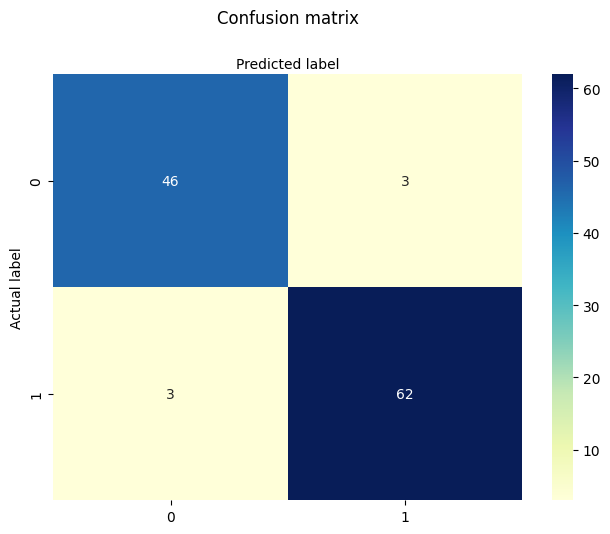

In [784]:
import seaborn as sns
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(confusion_matrix(ytest, ypred)), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

b.How about adding a weight penalty here, considering the number of parameters. Add the weight penalty and repeat the training and report the results.

In [785]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss

#--Model-From-sci-kit-here--#
xtrain = df_train.iloc[:,:-1]
ytrain = df_train.iloc[:,-1]

xtrain = xtrain.to_numpy()
ytrain = ytrain.to_numpy()
#LogRegression with l2 penalty by default
model = LogisticRegression(solver= 'lbfgs')
model.fit(xtrain, ytrain)



print(model.coef_)
print(log_loss(ytrain, model.predict_proba(xtrain)))
print(model.score(xtrain, ytrain))

[[-1.69815059 -1.62717229 -1.66871621 -1.44587333 -0.76268796 -0.3742021
  -1.40648283 -2.08258121 -0.62889937  0.91256396 -1.23761653 -0.30026684
  -0.96764595 -0.79813431 -0.19862597  0.58824848  0.18779847 -0.43672198
   0.17711606  0.53047701 -2.17284218 -2.22366818 -2.01428134 -1.57485237
  -1.59837568 -0.69895505 -1.2422253  -2.62382678 -1.1521128  -0.25710055]]
0.13300562820075953
0.9692307692307692


In [786]:
xtest = df_test.iloc[:,:-1]
ytest = df_test.iloc[:,-1]
xtest = xtest.to_numpy()
ytest = ytest.to_numpy()

ypred = model.predict(xtest)
ypred[0:9]

array([0., 1., 0., 1., 1., 1., 0., 0., 1.])

In [787]:
#Using confusion matrix to get accuracy:
from sklearn.metrics import confusion_matrix
confusion_matrix(ytest, ypred)


array([[45,  4],
       [ 0, 65]])

In [788]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
print("Accuracy", accuracy_score(ytest, ypred))
print("Precision", precision_score(ytest, ypred))
print("Recall", recall_score(ytest, ypred))
print ("F1 Score", f1_score(ytest, ypred))

Accuracy 0.9649122807017544
Precision 0.9420289855072463
Recall 1.0
F1 Score 0.9701492537313433


Text(0.5, 427.9555555555555, 'Predicted label')

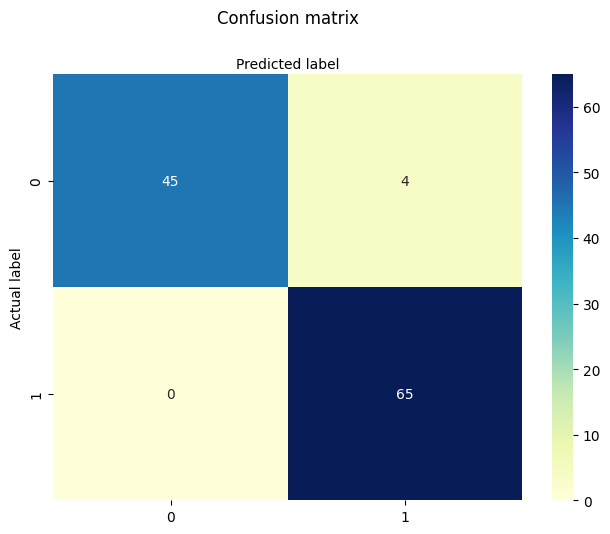

In [789]:
import seaborn as sns
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(confusion_matrix(ytest, ypred)), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')